###  Dim Configuration
input x = 1 x n_samples   
    -Pow + Sum >  
1 x n samples 
    -conv-> 
1 x n_samples x n_samples = resut y

In [67]:
### Generate data
import numpy as np
def Convolution(X, k, ConvW):
    """
    k is and odd number
    :param X: 1 x k, center is the current state
    :param k: kernel size
    :param ConvW: 1 x k

    :return: 1 x n_samples
    """
    y = np.zeros(1, dtype = np.complex128)
    for i in range(k):

        y += ConvW[i] * X[i]
    return y

def Polynomial(X, p ,PolyW, scaling_factor=0.1):
    """
    :param X: 1 x 1, complex number
    :param p: polynomial order, p = 3 means 1, 3, 5 
    :param PolyW: 1 x p coefficients
    :return: y : 1 x 1 complex number
    """
    ### PolyW should initailized small values to avoid large y values
    y = np.zeros(1,dtype = np.complex128)
    for i in range(p):
        y += PolyW[i]  * np.pow(np.abs(X * scaling_factor), i) * X
    return y

def Noise(X, noise_level):
    """
    :param X: 1 x 1, complex number
    :param noise_level: noise level
    :return: y: 1 x 1
    """
    return X + noise_level * np.random.randn(1)

def generate_data(n_samples, ConvW, PolyW, noise_level = 0.05, k = 3, p = 3 ):
    # generate complex data

    x = np.random.rand(n_samples) + 1j * np.random.rand(n_samples)  #  1 x n_samples


    ### Polynomial
    PolyX = np.zeros(n_samples, dtype = np.complex128)
    for i in range(n_samples):
        PolyX[i] = Polynomial(x[i], p, PolyW)[0]
    ### Noise
    # for i in range(n_samples):
    #     PolyX[i] = Noise(PolyX[i], noise_level)

    ### Convolution
    ConvX = np.zeros(n_samples, dtype = np.complex128)
    for i in range(k//2, n_samples-k//2):
        ConvX[i] = np.array((Convolution(PolyX[i-k//2:i+k//2+1], k, ConvW))[0])

    ### Noise
    # for i in range(n_samples):
    #     ConvX[i] = Noise(ConvX[i], noise_level)
    

    y = ConvX
    return x, y


### Generate Data

In [68]:

##  True parameters, complex 
scaling_factor = 0.1
n_samples = 5000
k = 3
p = 3 
noise_level = 0.05
## set seed
np.random.seed(3)

TruePolyW = np.random.rand(p) + 1j * np.random.rand(p)
for i in range(p):
    TruePolyW[i] = np.power(scaling_factor, i) * TruePolyW[i]
TrueConvW = np.random.rand(k) + 1j * np.random.rand(k)


x, y = generate_data(n_samples, TrueConvW, TruePolyW, noise_level, k,p)
print(x[:5])
print(y[:5])


[0.02398188+0.71798135j 0.55885409+0.74973634j 0.25925245+0.47610756j
 0.4151012 +0.54507576j 0.28352508+0.34640902j]
[ 0.        +0.j          0.        +0.j         -1.3975364 +0.16755742j
 -1.5310033 +0.17705797j -1.69079471+0.33324989j]


### Model Designing

In [69]:
### LMS 
def LMS_Filter(x, y, k, p, mu = 0.01, epoch = 10, scalingFactor = 0.1):    
    """
    :param x: 1 x n_samples
    :param y: 1 x n_samples
    :param k: kernel size
    :param p: polynomial order
    :param mu: learning rate
    :return: (ConvW, PolyW)
    """
    ### Initialization
    n_samples = len(x)
    ConvW = np.random.rand(k) + 1j * np.random.rand(k)
    PolyW = np.random.rand(p) + 1j * np.random.rand(p)
    for i in range(p):
        PolyW[i] = np.power(scalingFactor, i) * PolyW[i]

    ### LMS
    PolyRecord = []    
    ConvRecord = []
    ErrorRecord = []


    for j in range(epoch):
        for i in range(k//2, n_samples-k//2):
            
            # calculate error 
            PolyXs = np.zeros(k, dtype = np.complex128)
            for l in range(k):
                PolyXs[l] = Polynomial(x[i - k // 2 + l], p, PolyW)[0]
            ConvX = Convolution(PolyXs, k, ConvW)
            e = y[i] - ConvX

            # update coefficients
            ## ConvW
            ConvW += mu * e * np.conj(PolyXs)

            PolyXs = np.zeros(k, dtype = np.complex128)
            for l in range(k):
                PolyXs[l] = Polynomial(x[i - k // 2 + l], p, PolyW)[0]
            ConvX = Convolution(PolyXs, k, ConvW)
            e = y[i] - ConvX


            ## PolyW
            PartialKXP = np.zeros((k,p), dtype = np.complex128)
            for l in range(k):
                for m in range(p):
                    PartialKXP[l,m] = np.power(np.abs(x[i - k // 2 + l] * scalingFactor), m) * x[i - k // 2 + l]

            PolyW += mu * e * (np.dot( np.conj(ConvW), np.conj(PartialKXP)))


            PolyXs = np.zeros(k, dtype = np.complex128)
            for l in range(k):
                PolyXs[l] = Polynomial(x[i - k // 2 + l], p, PolyW)[0]
            ConvX = Convolution(PolyXs, k, ConvW)
            e = y[i] - ConvX
            
            ### calculate total error
            # print(i)
            if i % 100 ==  0 : 
                ERROR = np.zeros(1, dtype = np.complex128)
                for l in range(k//2, n_samples-k//2):
                    ConvX = Convolution(x[l-k//2:l+k//2+1], k, ConvW)
                    PolyX = Polynomial(ConvX, p, PolyW)
                    e = y[l] - PolyX
                    ERROR += np.abs(e)
                ErrorRecord.append(np.abs(ERROR))

            ConvRecord.append(ConvW.copy())
            PolyRecord.append(PolyW.copy())
    return ConvRecord, PolyRecord, ErrorRecord


### Example Usage

In [70]:
ConvRecord, PolyRecord, ErrorRecord = LMS_Filter(x, y, k, p, mu = 0.01, epoch = 10, scalingFactor = 0.1)

### Plot

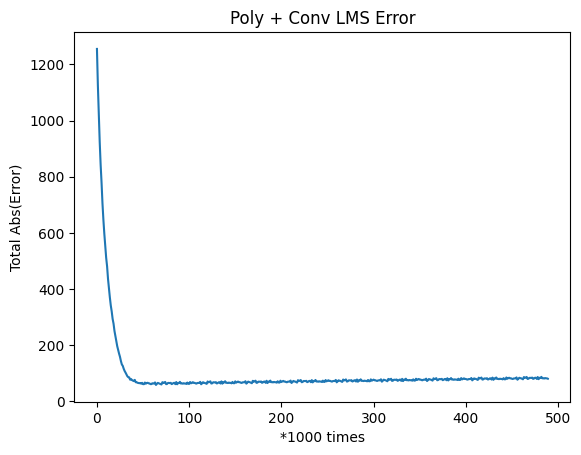

In [75]:
### plot the coefficients
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ErrorRecord)
plt.xlabel("*1000 times")
plt.ylabel("Total Abs(Error)")
plt.title("Poly + Conv LMS Error")
plt.show()  


In [73]:
ErrorRecord[-1] 

array([80.56208622])

In [76]:
ErrorRecord[-10] 

array([83.9987157])

In [77]:
ErrorRecord[-100] 

array([77.44409262])